<div style="text-align: center; padding: 2em 1em; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 12px; color: white; margin-bottom: 2em;">
  <h1 style="margin: 0; font-size: 2.5em; font-weight: 600; letter-spacing: -0.02em;">Метрики удержания (Retention Metrics)</h1>
  <p style="margin: 0.5em 0 0 0; font-size: 1.2em; opacity: 0.95;">Полное руководство по метрикам удержания пользователей в играх</p>
</div>

<div style="padding: 1.5em; background: #f8f9fa; border-left: 4px solid #667eea; border-radius: 6px; margin: 1em 0;">
  <p style="margin: 0; color: #2c3e50; line-height: 1.6; font-weight: 400;">
    <strong>Retention (удержание)</strong> — одна из самых важных метрик в игровой индустрии. 
    Она показывает, насколько хорошо игра удерживает пользователей, возвращаются ли они после первого запуска, 
    и как долго они остаются с продуктом. Высокий retention напрямую коррелирует с успехом игры и её монетизацией.
  </p>
</div>


In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Библиотеки загружены успешно")


✓ Библиотеки загружены успешно


## Генерация синтетических данных

Для демонстрации всех метрик создадим синтетический датасет с пользовательскими активностями.


In [4]:
# Устанавливаем seed для воспроизводимости
np.random.seed(42)

# Параметры датасета
n_users = 10000  # Количество пользователей
start_date = datetime(2024, 1, 1)  # Начальная дата
n_days = 60  # Период наблюдения

# Создаем пользователей с датами регистрации (когорты)
cohort_dates = pd.date_range(start=start_date, periods=30, freq='D')
users_data = []

for user_id in range(n_users):
    # Случайная дата регистрации
    install_date = np.random.choice(cohort_dates)
    users_data.append({
        'user_id': f'user_{user_id:05d}',
        'install_date': install_date
    })

users_df = pd.DataFrame(users_data)

# Генерируем активность пользователей с учетом естественного спада
activities = []

for idx, user in users_df.iterrows():
    install_date = user['install_date']
    user_id = user['user_id']
    
    # Вероятность возвращения зависит от дня (natural decay)
    # День 0 (установка) - 100%
    # День 1 - 40%
    # День 7 - 20%
    # День 30 - 10%
    
    # Добавляем день установки
    activities.append({
        'user_id': user_id,
        'event_date': install_date,
        'day_since_install': 0
    })
    
    # Симулируем последующую активность
    max_days = min(60, (start_date + timedelta(days=n_days) - install_date).days)
    
    for day in range(1, max_days):
        # Вероятность возвращения снижается экспоненциально
        base_probability = 0.45  # базовая вероятность D1
        decay_rate = 0.05  # скорость спада
        probability = base_probability * np.exp(-decay_rate * day)
        
        # Добавляем случайный шум
        probability += np.random.normal(0, 0.02)
        probability = max(0, min(1, probability))
        
        if np.random.random() < probability:
            event_date = install_date + timedelta(days=day)
            activities.append({
                'user_id': user_id,
                'event_date': event_date,
                'day_since_install': day
            })

activities_df = pd.DataFrame(activities)
activities_df['event_date'] = pd.to_datetime(activities_df['event_date'])

print(f"✓ Создано {len(users_df)} пользователей")
print(f"✓ Сгенерировано {len(activities_df)} событий активности")
print(f"\nПример данных пользователей:")
print(users_df.head())
print(f"\nПример данных активности:")
print(activities_df.head(10))


✓ Создано 10000 пользователей
✓ Сгенерировано 86876 событий активности

Пример данных пользователей:
      user_id install_date
0  user_00000   2024-01-07
1  user_00001   2024-01-20
2  user_00002   2024-01-29
3  user_00003   2024-01-15
4  user_00004   2024-01-11

Пример данных активности:
      user_id event_date  day_since_install
0  user_00000 2024-01-07                  0
1  user_00000 2024-01-08                  1
2  user_00000 2024-01-09                  2
3  user_00000 2024-01-10                  3
4  user_00000 2024-01-13                  6
5  user_00000 2024-01-16                  9
6  user_00000 2024-01-21                 14
7  user_00000 2024-01-22                 15
8  user_00000 2024-01-26                 19
9  user_00000 2024-02-15                 39


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #667eea;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">1. Day-1 Retention (D1 Retention)</h2>
</div>

### 📍 Определение

**Day-1 Retention (D1)** — процент пользователей, которые вернулись в игру на следующий день после установки.

### 📍 Формула расчета

$$
\text{D1 Retention} = \frac{\text{Количество пользователей, вернувшихся на Day 1}}{\text{Количество установивших игру в Day 0}} \times 100\%
$$

Где:
- **Day 0** — день установки игры
- **Day 1** — следующий календарный день после установки (через 24 часа)

### 📍 Зачем нужна метрика

D1 Retention — **критически важная метрика** для мобильных игр, так как она:

1. **Показывает качество первого впечатления (First Time User Experience, FTUE)**
   - Насколько хорошо игра зацепила пользователя в первый день
   - Качество онбординга и туториала

2. **Является ранним индикатором успеха игры**
   - Можно быстро оценить (на следующий день после запуска)
   - Не нужно ждать 7 или 30 дней

3. **Влияет на экономику привлечения**
   - Низкий D1 = впустую потраченные деньги на UA
   - Высокий D1 = больше шансов на окупаемость

4. **Коррелирует с долгосрочным удержанием**
   - Пользователи с хорошим D1 чаще остаются надолго

### 📍 Что показывает

- **Высокий D1 (>40%)** — игра отлично зацепила пользователей, сильный core loop, интересный контент
- **Средний D1 (25-40%)** — нормальный уровень для большинства жанров
- **Низкий D1 (<25%)** — проблемы с первым впечатлением, сложный онбординг, скучный геймплей

### 📍 На что влияет

1. **LTV (Lifetime Value)** — пользователи с хорошим D1 приносят больше денег
2. **ROI юнит-экономики** — влияет на окупаемость затрат на привлечение
3. **Organic growth** — довольные пользователи приводят друзей
4. **D7 и D30 retention** — является фундаментом для долгосрочного удержания

### 📍 Что на нее влияет

**Позитивно влияют:**
- ✅ Простой и понятный туториал
- ✅ Быстрая загрузка игры
- ✅ Ранняя награда/достижение (quick win)
- ✅ Социальные элементы (друзья, гильдии)
- ✅ Push-уведомления (напоминания)
- ✅ Daily rewards (ежедневные награды)

**Негативно влияют:**
- ❌ Сложный или длинный онбординг
- ❌ Технические проблемы (краши, лаги)
- ❌ Отсутствие контента для новичков
- ❌ Слишком агрессивная монетизация в первый день
- ❌ Плохой баланс сложности (слишком легко или сложно)

### 📍 Бенчмарки и нормальные значения

| Жанр игры | Хороший D1 | Средний D1 | Низкий D1 |
|-----------|------------|------------|-----------|
| Hypercasual | 25-35% | 15-25% | <15% |
| Casual/Puzzle | 35-45% | 25-35% | <25% |
| Match-3 | 40-50% | 30-40% | <30% |
| Strategy/4X | 35-45% | 25-35% | <25% |
| RTS | 30-40% | 20-30% | <20% |
| RPG | 40-50% | 30-40% | <30% |
| Idle/Incremental | 45-55% | 35-45% | <35% |
| Social Casino | 30-40% | 20-30% | <20% |
| Battle Royale | 25-35% | 15-25% | <15% |

**Факторы, влияющие на бенчмарки:**
- Платформа (iOS обычно выше Android на 5-10%)
- Качество трафика (organic vs paid)
- Регион (разные рынки имеют разные показатели)
- Сезонность (праздники могут повысить retention)

### 📍 Как улучшить D1 Retention

1. **Оптимизация FTUE (First Time User Experience)**
   - Сократить туториал до минимума
   - Показывать, а не рассказывать (show, don't tell)
   - Дать почувствовать core loop в первые 3-5 минут

2. **Quick Wins (Быстрые победы)**
   - Первая победа/достижение в первые минуты
   - Ранние награды и прогресс

3. **Push-уведомления**
   - Отправлять напоминание через 12-18 часов после установки
   - Персонализированные сообщения

4. **Daily Login Rewards**
   - Показать систему наград уже в день установки
   - Создать ожидание завтрашней награды

5. **Социальные элементы**
   - Интеграция с друзьями из соцсетей
   - Пригласительные бонусы

6. **A/B тестирование**
   - Постоянно тестировать изменения в FTUE
   - Анализировать drop-off points


### 📍 Расчет D1 Retention на Python


In [5]:
def calculate_d1_retention(users_df, activities_df):
    """
    Рассчитывает D1 Retention для каждой когорты
    
    Parameters:
    -----------
    users_df : pd.DataFrame
        DataFrame с пользователями и датами установки
    activities_df : pd.DataFrame
        DataFrame с активностью пользователей
    
    Returns:
    --------
    pd.DataFrame
        Таблица с D1 retention по когортам
    """
    
    results = []
    
    # Группируем пользователей по дате установки (когорте)
    for install_date in users_df['install_date'].unique():
        # Пользователи этой когорты
        cohort_users = users_df[users_df['install_date'] == install_date]['user_id'].unique()
        cohort_size = len(cohort_users)
        
        # День 1 для этой когорты
        day1_date = install_date + timedelta(days=1)
        
        # Пользователи, которые вернулись на Day 1
        day1_activities = activities_df[
            (activities_df['event_date'] == day1_date) &
            (activities_df['user_id'].isin(cohort_users))
        ]
        
        returned_users = day1_activities['user_id'].nunique()
        
        # Рассчитываем D1 retention
        d1_retention = (returned_users / cohort_size * 100) if cohort_size > 0 else 0
        
        results.append({
            'install_date': install_date,
            'cohort_size': cohort_size,
            'returned_day1': returned_users,
            'd1_retention': d1_retention
        })
    
    return pd.DataFrame(results).sort_values('install_date')

# Рассчитываем D1 retention
d1_results = calculate_d1_retention(users_df, activities_df)

# Выводим результаты
print("=" * 80)
print("D1 RETENTION ПО КОГОРТАМ")
print("=" * 80)
print(d1_results.head(10).to_string(index=False))
print("\n")
print(f"Средний D1 Retention: {d1_results['d1_retention'].mean():.2f}%")
print(f"Медианный D1 Retention: {d1_results['d1_retention'].median():.2f}%")
print(f"Минимальный D1 Retention: {d1_results['d1_retention'].min():.2f}%")
print(f"Максимальный D1 Retention: {d1_results['d1_retention'].max():.2f}%")


D1 RETENTION ПО КОГОРТАМ
install_date  cohort_size  returned_day1  d1_retention
  2024-01-01          313            137     43.769968
  2024-01-02          331            135     40.785498
  2024-01-03          336            155     46.130952
  2024-01-04          336            139     41.369048
  2024-01-05          325            142     43.692308
  2024-01-06          316            120     37.974684
  2024-01-07          295            134     45.423729
  2024-01-08          344            148     43.023256
  2024-01-09          302            124     41.059603
  2024-01-10          314            138     43.949045


Средний D1 Retention: 43.07%
Медианный D1 Retention: 42.96%
Минимальный D1 Retention: 37.97%
Максимальный D1 Retention: 46.39%


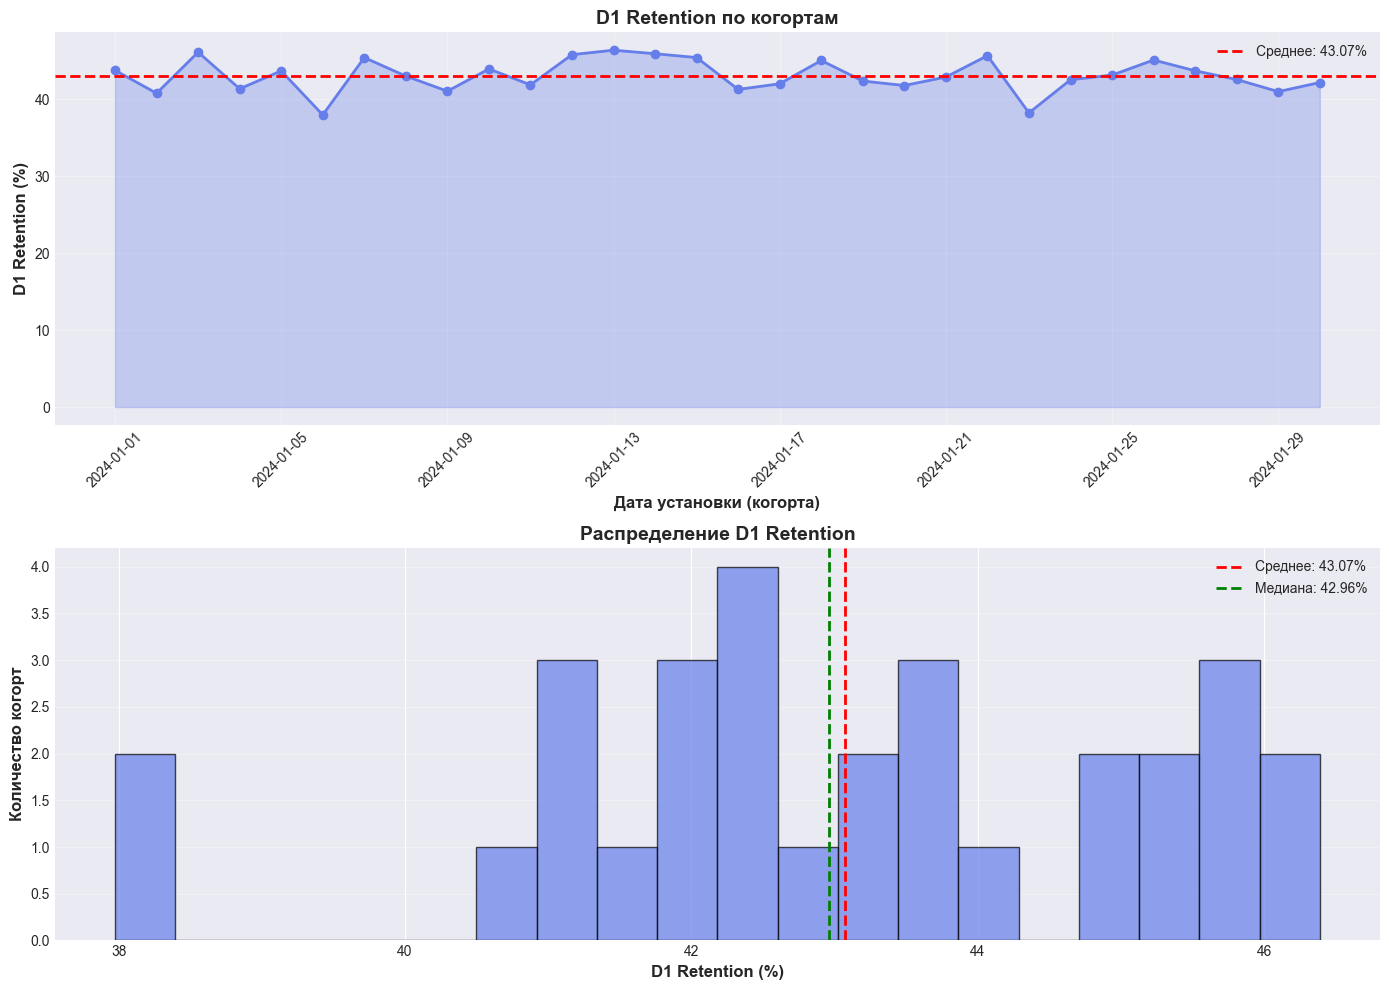


ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА D1 RETENTION
Стандартное отклонение: 2.19%
Коэффициент вариации: 5.08%

Перцентили:
  25%: 41.82%
  50%: 42.96%
  75%: 45.09%
  90%: 45.82%


In [6]:
# Визуализация D1 Retention по когортам
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# График 1: D1 Retention по времени
axes[0].plot(d1_results['install_date'], d1_results['d1_retention'], 
             marker='o', linewidth=2, markersize=6, color='#667eea')
axes[0].axhline(y=d1_results['d1_retention'].mean(), 
                color='red', linestyle='--', linewidth=2, 
                label=f'Среднее: {d1_results["d1_retention"].mean():.2f}%')
axes[0].fill_between(d1_results['install_date'], 
                      d1_results['d1_retention'], 
                      alpha=0.3, color='#667eea')
axes[0].set_xlabel('Дата установки (когорта)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('D1 Retention (%)', fontsize=12, fontweight='bold')
axes[0].set_title('D1 Retention по когортам', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# График 2: Распределение D1 Retention
axes[1].hist(d1_results['d1_retention'], bins=20, color='#667eea', 
             alpha=0.7, edgecolor='black')
axes[1].axvline(x=d1_results['d1_retention'].mean(), 
                color='red', linestyle='--', linewidth=2, 
                label=f'Среднее: {d1_results["d1_retention"].mean():.2f}%')
axes[1].axvline(x=d1_results['d1_retention'].median(), 
                color='green', linestyle='--', linewidth=2, 
                label=f'Медиана: {d1_results["d1_retention"].median():.2f}%')
axes[1].set_xlabel('D1 Retention (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Количество когорт', fontsize=12, fontweight='bold')
axes[1].set_title('Распределение D1 Retention', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\n" + "=" * 80)
print("ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА D1 RETENTION")
print("=" * 80)
print(f"Стандартное отклонение: {d1_results['d1_retention'].std():.2f}%")
print(f"Коэффициент вариации: {(d1_results['d1_retention'].std() / d1_results['d1_retention'].mean() * 100):.2f}%")
print(f"\nПерцентили:")
print(f"  25%: {d1_results['d1_retention'].quantile(0.25):.2f}%")
print(f"  50%: {d1_results['d1_retention'].quantile(0.50):.2f}%")
print(f"  75%: {d1_results['d1_retention'].quantile(0.75):.2f}%")
print(f"  90%: {d1_results['d1_retention'].quantile(0.90):.2f}%")


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 2em 0 1em 0; border-left: 4px solid #667eea;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">2. Day-7 Retention (D7 Retention)</h2>
</div>

### 📍 Определение

**Day-7 Retention (D7)** — процент пользователей, которые вернулись в игру на 7-й день после установки.

### 📍 Формула расчета

$$
\text{D7 Retention} = \frac{\text{Количество пользователей, вернувшихся на Day 7}}{\text{Количество установивших игру в Day 0}} \times 100\%
$$

Где:
- **Day 0** — день установки игры
- **Day 7** — ровно 7 дней после установки

### 📍 Зачем нужна метрика

D7 Retention — **ключевая метрика среднесрочного удержания**, так как она:

1. **Показывает силу core loop и mid-game**
   - Пользователи уже прошли онбординг и попробовали основной геймплей
   - Оценивается глубина контента и реиграбельность

2. **Индикатор вовлеченности**
   - Через неделю пользователи принимают решение: оставаться или уходить
   - Формируются игровые привычки

3. **Предиктор LTV**
   - Сильная корреляция с долгосрочной монетизацией
   - Пользователи с хорошим D7 обычно платят

4. **Метрика для оценки обновлений**
   - Достаточно времени для оценки эффекта изменений
   - Не слишком долгое ожидание (в отличие от D30)

### 📍 Что показывает

- **Высокий D7 (>20%)** — сильный core loop, достаточно контента, хорошая вовлеченность
- **Средний D7 (10-20%)** — нормальный уровень для большинства жанров
- **Низкий D7 (<10%)** — проблемы с контентом, слабый core loop, недостаточная глубина

**Типичное соотношение:** D7 = 40-60% от D1

### 📍 На что влияет

1. **LTV (Lifetime Value)** — основной предиктор долгосрочной ценности пользователя
2. **Монетизация** — большинство первых покупок происходит в первые 7 дней
3. **D30 Retention** — является базой для долгосрочного удержания
4. **Organic virality** — довольные пользователи приводят друзей

### 📍 Что на нее влияет

**Позитивно влияют:**
- ✅ Глубокий и интересный core loop
- ✅ Достаточное количество контента на первую неделю
- ✅ Прогрессия без пайволов (paywall)
- ✅ События и активности на первой неделе
- ✅ Push-уведомления (3-4 раза за неделю)
- ✅ Daily rewards и streak механики
- ✅ Социальные features (гильдии, друзья)
- ✅ Регулярные обновления контента

**Негативно влияют:**
- ❌ Недостаток контента ("content wall")
- ❌ Слишком быстрая или медленная прогрессия
- ❌ Агрессивные пайволы
- ❌ Повторяющийся геймплей без разнообразия
- ❌ Технические проблемы
- ❌ Отсутствие целей среднего срока

### 📍 Бенчмарки и нормальные значения

| Жанр игры | Хороший D7 | Средний D7 | Низкий D7 |
|-----------|------------|------------|-----------|
| Hypercasual | 10-15% | 5-10% | <5% |
| Casual/Puzzle | 15-25% | 10-15% | <10% |
| Match-3 | 20-30% | 15-20% | <15% |
| Strategy/4X | 20-30% | 15-20% | <15% |
| RTS | 18-25% | 12-18% | <12% |
| RPG | 25-35% | 18-25% | <18% |
| Idle/Incremental | 30-40% | 20-30% | <20% |
| Social Casino | 15-25% | 10-15% | <10% |
| Battle Royale | 12-20% | 8-12% | <8% |

**Типичные соотношения:**
- D7 ≈ 40-60% от D1
- D7 ≈ 2-3x от D30

### 📍 Как улучшить D7 Retention

1. **Оптимизация прогрессии**
   - Обеспечить плавную кривую сложности
   - Убрать "content walls" на первой неделе
   - Добавить промежуточные цели

2. **События и активности**
   - Запуск event'ов для новичков
   - Специальные миссии на неделю
   - Limited-time предложения

3. **Социализация**
   - Ранняя интеграция с гильдиями/кланами
   - Кооперативные механики
   - Соревнования между игроками

4. **Daily engagement**
   - Login streaks (серии входов)
   - Daily missions/quests
   - Rotating content

5. **Push-стратегия**
   - Напоминания о незавершенных действиях
   - Уведомления о событиях
   - Персонализированные сообщения

6. **Контент на первую неделю**
   - Достаточное количество уровней/контента
   - Разблокировка новых механик постепенно
   - Сюрпризы и открытия

### 📍 Расчет D7 Retention на Python


In [12]:
def calculate_dn_retention(users_df, activities_df, n=7):
    """
    Универсальная функция для расчета D-N Retention
    
    Parameters:
    -----------
    users_df : pd.DataFrame
        DataFrame с пользователями и датами установки
    activities_df : pd.DataFrame
        DataFrame с активностью пользователей
    n : int
        День для расчета retention (1, 7, 30, и т.д.)
    
    Returns:
    --------
    pd.DataFrame
        Таблица с retention по когортам
    """
    
    results = []
    
    for install_date in users_df['install_date'].unique():
        cohort_users = users_df[users_df['install_date'] == install_date]['user_id'].unique()
        cohort_size = len(cohort_users)
        
        target_date = install_date + timedelta(days=n)
        
        returned_activities = activities_df[
            (activities_df['event_date'] == target_date) &
            (activities_df['user_id'].isin(cohort_users))
        ]
        
        returned_users = returned_activities['user_id'].nunique()
        retention = (returned_users / cohort_size * 100) if cohort_size > 0 else 0
        
        results.append({
            'install_date': install_date,
            'cohort_size': cohort_size,
            f'returned_day{n}': returned_users,
            f'd{n}_retention': retention
        })
    
    return pd.DataFrame(results).sort_values('install_date')

# Рассчитываем D7 retention
d7_results = calculate_dn_retention(users_df, activities_df, n=7)

print("=" * 80)
print("D7 RETENTION ПО КОГОРТАМ")
print("=" * 80)
print(d7_results.head(10).to_string(index=False))
print("\n")
print(f"Средний D7 Retention: {d7_results['d7_retention'].mean():.2f}%")
print(f"Медианный D7 Retention: {d7_results['d7_retention'].median():.2f}%")
print(f"Минимальный D7 Retention: {d7_results['d7_retention'].min():.2f}%")
print(f"Максимальный D7 Retention: {d7_results['d7_retention'].max():.2f}%")

# Сравнение с D1
comparison_df = pd.merge(
    d1_results[['install_date', 'd1_retention']], 
    d7_results[['install_date', 'd7_retention']], 
    on='install_date'
)
comparison_df['d7_to_d1_ratio'] = (comparison_df['d7_retention'] / comparison_df['d1_retention'] * 100)

print("\n" + "=" * 80)
print("СРАВНЕНИЕ D1 И D7 RETENTION")
print("=" * 80)
print(f"Среднее соотношение D7/D1: {comparison_df['d7_to_d1_ratio'].mean():.2f}%")
print(f"D7 составляет {comparison_df['d7_to_d1_ratio'].mean():.1f}% от D1")


D7 RETENTION ПО КОГОРТАМ
install_date  cohort_size  returned_day7  d7_retention
  2024-01-01          313             91     29.073482
  2024-01-02          331            100     30.211480
  2024-01-03          336            128     38.095238
  2024-01-04          336            116     34.523810
  2024-01-05          325            114     35.076923
  2024-01-06          316             97     30.696203
  2024-01-07          295             88     29.830508
  2024-01-08          344            111     32.267442
  2024-01-09          302             91     30.132450
  2024-01-10          314             89     28.343949


Средний D7 Retention: 31.58%
Медианный D7 Retention: 31.15%
Минимальный D7 Retention: 27.27%
Максимальный D7 Retention: 38.10%

СРАВНЕНИЕ D1 И D7 RETENTION
Среднее соотношение D7/D1: 73.44%
D7 составляет 73.4% от D1


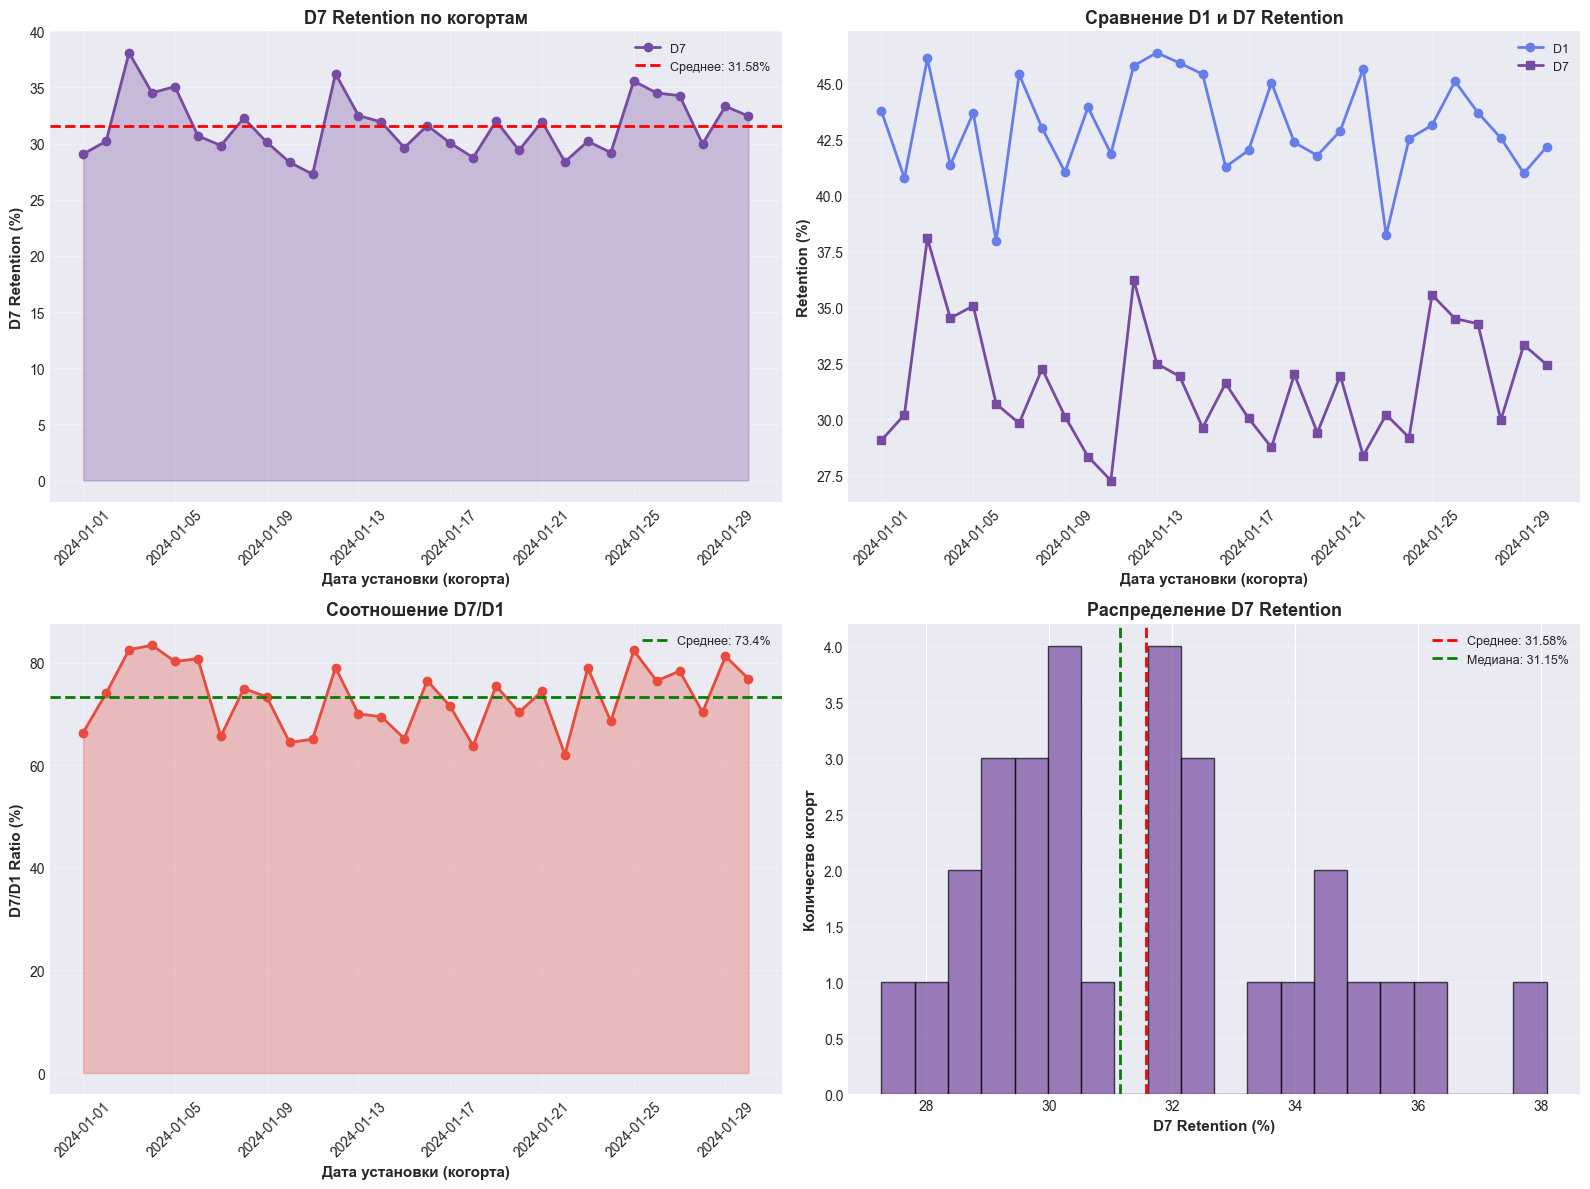

In [13]:
# Визуализация D7 и сравнение с D1
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: D7 Retention по времени
axes[0, 0].plot(d7_results['install_date'], d7_results['d7_retention'], 
                marker='o', linewidth=2, markersize=6, color='#764ba2', label='D7')
axes[0, 0].axhline(y=d7_results['d7_retention'].mean(), 
                   color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее: {d7_results["d7_retention"].mean():.2f}%')
axes[0, 0].fill_between(d7_results['install_date'], 
                        d7_results['d7_retention'], 
                        alpha=0.3, color='#764ba2')
axes[0, 0].set_xlabel('Дата установки (когорта)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('D7 Retention (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('D7 Retention по когортам', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=9)
axes[0, 0].tick_params(axis='x', rotation=45)

# График 2: Сравнение D1 и D7
axes[0, 1].plot(comparison_df['install_date'], comparison_df['d1_retention'], 
                marker='o', linewidth=2, markersize=6, color='#667eea', label='D1')
axes[0, 1].plot(comparison_df['install_date'], comparison_df['d7_retention'], 
                marker='s', linewidth=2, markersize=6, color='#764ba2', label='D7')
axes[0, 1].set_xlabel('Дата установки (когорта)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Retention (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Сравнение D1 и D7 Retention', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=9)
axes[0, 1].tick_params(axis='x', rotation=45)

# График 3: Соотношение D7/D1
axes[1, 0].plot(comparison_df['install_date'], comparison_df['d7_to_d1_ratio'], 
                marker='o', linewidth=2, markersize=6, color='#e74c3c')
axes[1, 0].axhline(y=comparison_df['d7_to_d1_ratio'].mean(), 
                   color='green', linestyle='--', linewidth=2, 
                   label=f'Среднее: {comparison_df["d7_to_d1_ratio"].mean():.1f}%')
axes[1, 0].fill_between(comparison_df['install_date'], 
                        comparison_df['d7_to_d1_ratio'], 
                        alpha=0.3, color='#e74c3c')
axes[1, 0].set_xlabel('Дата установки (когорта)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('D7/D1 Ratio (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Соотношение D7/D1', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=9)
axes[1, 0].tick_params(axis='x', rotation=45)

# График 4: Распределение D7 Retention
axes[1, 1].hist(d7_results['d7_retention'], bins=20, color='#764ba2', 
                alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=d7_results['d7_retention'].mean(), 
                   color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее: {d7_results["d7_retention"].mean():.2f}%')
axes[1, 1].axvline(x=d7_results['d7_retention'].median(), 
                   color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана: {d7_results["d7_retention"].median():.2f}%')
axes[1, 1].set_xlabel('D7 Retention (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Количество когорт', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Распределение D7 Retention', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend(fontsize=9)

plt.tight_layout()
plt.show()


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 2em 0 1em 0; border-left: 4px solid #667eea;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">3. Day-30 Retention (D30 Retention)</h2>
</div>

### 📍 Определение

**Day-30 Retention (D30)** — процент пользователей, которые вернулись в игру на 30-й день после установки.

### 📍 Формула расчета

$$
\text{D30 Retention} = \frac{\text{Количество пользователей, вернувшихся на Day 30}}{\text{Количество установивших игру в Day 0}} \times 100\%
$$

### 📍 Зачем нужна метрика

D30 Retention — **ключевая метрика долгосрочного удержания**:

1. **Индикатор лояльности** — пользователи стали постоянными игроками
2. **Сильнейший предиктор LTV** — практически прямая корреляция с lifetime value
3. **Показатель качества end-game контента** — достаточно ли глубины в игре
4. **Метрика устойчивости бизнеса** — стабильная база активных пользователей

### 📍 Что показывает

- **Высокий D30 (>10%)** — игра имеет глубину, сильный end-game, постоянную базу игроков
- **Средний D30 (5-10%)** — нормальный уровень
- **Низкий D30 (<5%)** — проблемы с долгосрочной вовлеченностью

**Типичные соотношения:**
- D30 ≈ 30-50% от D7
- D30 ≈ 10-25% от D1

### 📍 Бенчмарки

| Жанр игры | Хороший D30 | Средний D30 | Низкий D30 |
|-----------|-------------|-------------|------------|
| Hypercasual | 3-5% | 1-3% | <1% |
| Casual/Puzzle | 8-12% | 5-8% | <5% |
| Match-3 | 12-18% | 8-12% | <8% |
| Strategy/4X | 15-25% | 10-15% | <10% |
| RTS | 12-20% | 8-12% | <8% |
| RPG | 18-28% | 12-18% | <12% |
| Idle/Incremental | 20-30% | 15-20% | <15% |
| Social Casino | 10-15% | 5-10% | <5% |
| Battle Royale | 8-15% | 5-8% | <5% |

### 📍 Как улучшить D30 Retention

1. **End-game контент**
   - PvP/Guild wars
   - Эндгейм ивенты
   - Престиж/реинкарнация системы

2. **Социальные связи**
   - Сильные гильдии
   - Друзья и альянсы
   - Соревнования

3. **Live-ops**
   - Регулярные ивенты
   - Новый контент
   - Сезоны и баттл-пассы

4. **Мета-игра**
   - Коллекции
   - Достижения
   - Долгосрочные цели


D30 RETENTION ПО КОГОРТАМ
install_date  cohort_size  returned_day30  d30_retention
  2024-01-01          313              25       7.987220
  2024-01-02          331              37      11.178248
  2024-01-03          336              38      11.309524
  2024-01-04          336              31       9.226190
  2024-01-05          325              24       7.384615
  2024-01-06          316              28       8.860759
  2024-01-07          295              32      10.847458
  2024-01-08          344              33       9.593023
  2024-01-09          302              32      10.596026
  2024-01-10          314              35      11.146497

Средний D30 Retention: 10.12%


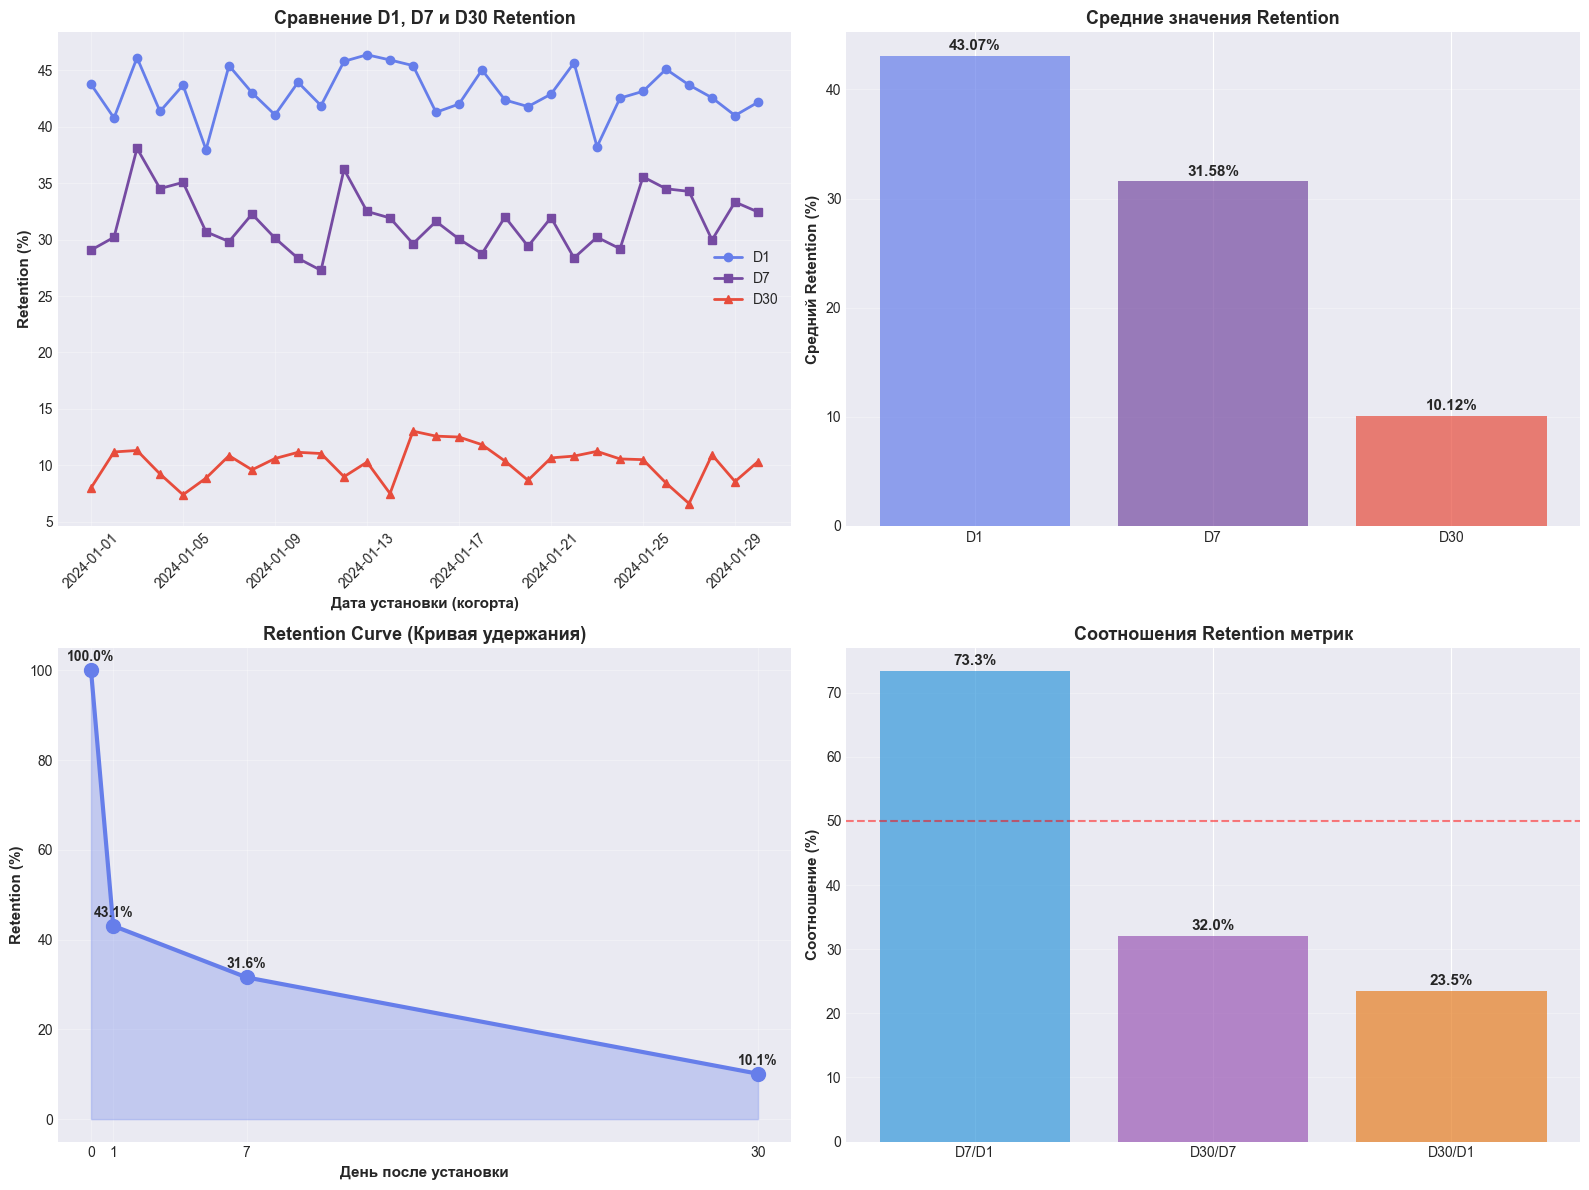


SUMMARY: СООТНОШЕНИЯ RETENTION МЕТРИК
D7/D1: 73.32%
D30/D7: 32.03%
D30/D1: 23.48%


In [14]:
# Рассчитываем D30 retention
d30_results = calculate_dn_retention(users_df, activities_df, n=30)

print("=" * 80)
print("D30 RETENTION ПО КОГОРТАМ")
print("=" * 80)
print(d30_results.head(10).to_string(index=False))
print(f"\nСредний D30 Retention: {d30_results['d30_retention'].mean():.2f}%")

# Объединяем все retention метрики
full_comparison = pd.merge(
    d1_results[['install_date', 'd1_retention']], 
    d7_results[['install_date', 'd7_retention']], 
    on='install_date'
)
full_comparison = pd.merge(
    full_comparison,
    d30_results[['install_date', 'd30_retention']], 
    on='install_date'
)

# Визуализация всех retention метрик вместе
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Все retention метрики на одном графике
axes[0, 0].plot(full_comparison['install_date'], full_comparison['d1_retention'], 
                marker='o', linewidth=2, label='D1', color='#667eea')
axes[0, 0].plot(full_comparison['install_date'], full_comparison['d7_retention'], 
                marker='s', linewidth=2, label='D7', color='#764ba2')
axes[0, 0].plot(full_comparison['install_date'], full_comparison['d30_retention'], 
                marker='^', linewidth=2, label='D30', color='#e74c3c')
axes[0, 0].set_xlabel('Дата установки (когорта)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Retention (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Сравнение D1, D7 и D30 Retention', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)

# График 2: Средние значения retention
avg_retention = {
    'D1': full_comparison['d1_retention'].mean(),
    'D7': full_comparison['d7_retention'].mean(),
    'D30': full_comparison['d30_retention'].mean()
}
axes[0, 1].bar(avg_retention.keys(), avg_retention.values(), 
               color=['#667eea', '#764ba2', '#e74c3c'], alpha=0.7)
axes[0, 1].set_ylabel('Средний Retention (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Средние значения Retention', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, (key, value) in enumerate(avg_retention.items()):
    axes[0, 1].text(i, value + 0.5, f'{value:.2f}%', 
                    ha='center', fontweight='bold', fontsize=11)

# График 3: Retention curve (кривая удержания)
days = [0, 1, 7, 30]
retention_curve = [
    100, 
    full_comparison['d1_retention'].mean(),
    full_comparison['d7_retention'].mean(),
    full_comparison['d30_retention'].mean()
]
axes[1, 0].plot(days, retention_curve, marker='o', linewidth=3, 
                markersize=10, color='#667eea')
axes[1, 0].fill_between(days, retention_curve, alpha=0.3, color='#667eea')
axes[1, 0].set_xlabel('День после установки', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Retention (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Retention Curve (Кривая удержания)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)
for i, (day, ret) in enumerate(zip(days, retention_curve)):
    axes[1, 0].text(day, ret + 2, f'{ret:.1f}%', ha='center', fontweight='bold')

# График 4: Соотношения retention метрик
ratios = {
    'D7/D1': (full_comparison['d7_retention'].mean() / full_comparison['d1_retention'].mean() * 100),
    'D30/D7': (full_comparison['d30_retention'].mean() / full_comparison['d7_retention'].mean() * 100),
    'D30/D1': (full_comparison['d30_retention'].mean() / full_comparison['d1_retention'].mean() * 100)
}
axes[1, 1].bar(ratios.keys(), ratios.values(), 
               color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.7)
axes[1, 1].set_ylabel('Соотношение (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Соотношения Retention метрик', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
for i, (key, value) in enumerate(ratios.items()):
    axes[1, 1].text(i, value + 1, f'{value:.1f}%', 
                    ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("SUMMARY: СООТНОШЕНИЯ RETENTION МЕТРИК")
print("=" * 80)
for key, value in ratios.items():
    print(f"{key}: {value:.2f}%")


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 2em 0 1em 0; border-left: 4px solid #667eea;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">4. Rolling Retention</h2>
</div>

### 📍 Определение

**Rolling Retention** (также известный как **Return On or After Day N**) — процент пользователей, которые вернулись в игру **на N-й день или позже**.

### 📍 Формула расчета

$$
\text{Rolling Retention (Day N)} = \frac{\text{Пользователи, вернувшиеся на Day N или после}}{\text{Установившие в Day 0}} \times 100\%
$$

### 📍 Зачем нужна метрика

**Отличие от классического retention:**
- **Classic Retention** — возврат **строго в день N**
- **Rolling Retention** — возврат **в день N или позже**

Rolling Retention:
1. **Более щадящая метрика** — учитывает нерегулярное поведение пользователей
2. **Лучше для casual игр** — пользователи могут играть не каждый день
3. **Показывает общую заинтересованность** — пользователь не ушел навсегда
4. **Более стабильная метрика** — меньше волатильности

### 📍 Когда использовать

**Используйте Rolling Retention для:**
- ✅ Casual и puzzle игр (не требуют ежедневного входа)
- ✅ Weekend games (игры выходного дня)
- ✅ Игр без строгого daily engagement
- ✅ Общей оценки интереса к игре

**Используйте Classic Retention для:**
- ✅ Games with daily rewards (требуют ежедневного входа)
- ✅ Live-ops heavy games (много событий)
- ✅ Competitive games (PvP, guild wars)
- ✅ Оценки привычек пользователей

### 📍 Расчет Rolling Retention


ROLLING D7 RETENTION VS CLASSIC D7 RETENTION
install_date  d7_retention  rolling_d7_retention  difference
  2024-01-01     29.073482            100.000000   70.926518
  2024-01-02     30.211480            100.000000   69.788520
  2024-01-03     38.095238             99.107143   61.011905
  2024-01-04     34.523810            100.000000   65.476190
  2024-01-05     35.076923            100.000000   64.923077
  2024-01-06     30.696203             99.683544   68.987342
  2024-01-07     29.830508            100.000000   70.169492
  2024-01-08     32.267442             99.709302   67.441860
  2024-01-09     30.132450            100.000000   69.867550
  2024-01-10     28.343949            100.000000   71.656051


Средний Classic D7: 31.58%
Средний Rolling D7: 99.80%
Разница: +68.21%


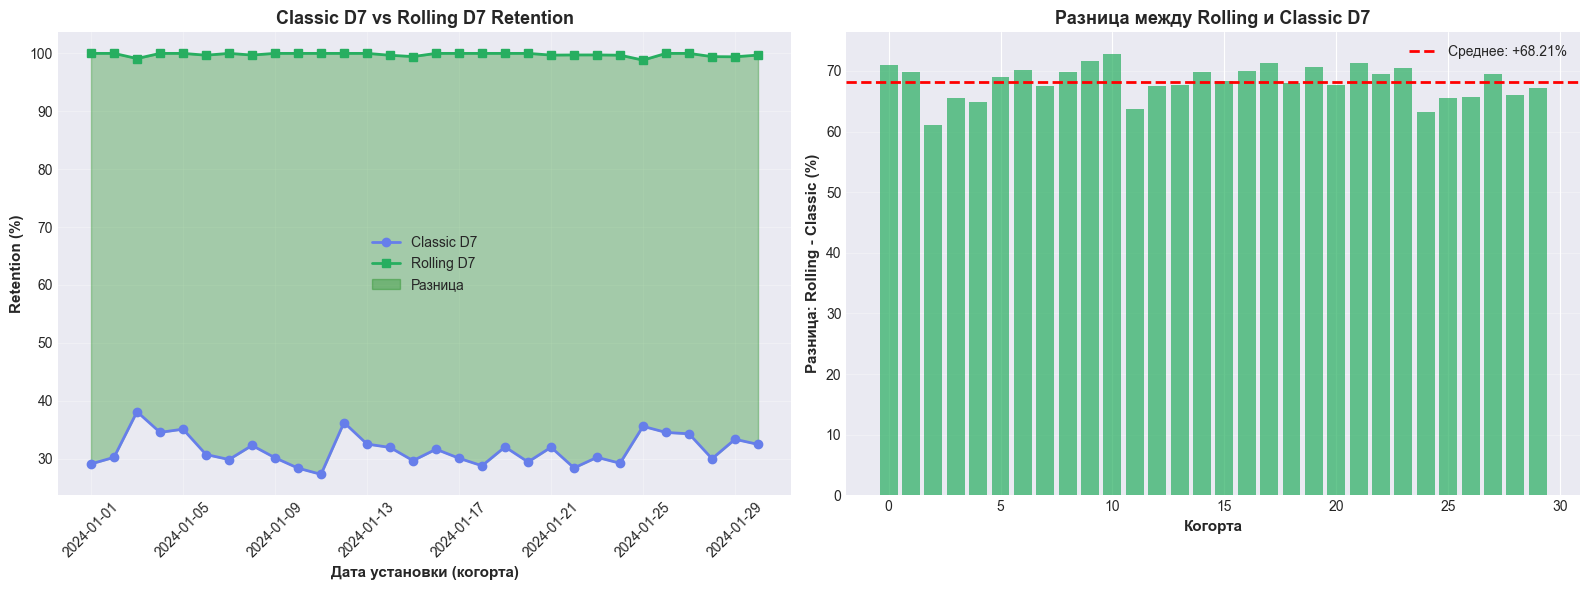

In [15]:
def calculate_rolling_retention(users_df, activities_df, n=7):
    """
    Рассчитывает Rolling Retention (Return On or After Day N)
    
    Parameters:
    -----------
    users_df : pd.DataFrame
        DataFrame с пользователями и датами установки
    activities_df : pd.DataFrame
        DataFrame с активностью пользователей
    n : int
        День для расчета retention
    
    Returns:
    --------
    pd.DataFrame
        Таблица с rolling retention по когортам
    """
    
    results = []
    
    for install_date in users_df['install_date'].unique():
        cohort_users = users_df[users_df['install_date'] == install_date]['user_id'].unique()
        cohort_size = len(cohort_users)
        
        # День N или позже
        target_date = install_date + timedelta(days=n)
        
        # Пользователи, которые вернулись на Day N или после
        returned_activities = activities_df[
            (activities_df['event_date'] >= target_date) &
            (activities_df['user_id'].isin(cohort_users))
        ]
        
        returned_users = returned_activities['user_id'].nunique()
        rolling_retention = (returned_users / cohort_size * 100) if cohort_size > 0 else 0
        
        results.append({
            'install_date': install_date,
            'cohort_size': cohort_size,
            f'returned_day{n}_plus': returned_users,
            f'rolling_d{n}_retention': rolling_retention
        })
    
    return pd.DataFrame(results).sort_values('install_date')

# Рассчитываем Rolling D7 retention
rolling_d7_results = calculate_rolling_retention(users_df, activities_df, n=7)

print("=" * 80)
print("ROLLING D7 RETENTION VS CLASSIC D7 RETENTION")
print("=" * 80)

# Сравниваем с классическим D7
comparison_rolling = pd.merge(
    d7_results[['install_date', 'd7_retention']],
    rolling_d7_results[['install_date', 'rolling_d7_retention']],
    on='install_date'
)

comparison_rolling['difference'] = comparison_rolling['rolling_d7_retention'] - comparison_rolling['d7_retention']

print(comparison_rolling.head(10).to_string(index=False))
print("\n")
print(f"Средний Classic D7: {comparison_rolling['d7_retention'].mean():.2f}%")
print(f"Средний Rolling D7: {comparison_rolling['rolling_d7_retention'].mean():.2f}%")
print(f"Разница: +{comparison_rolling['difference'].mean():.2f}%")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Сравнение Classic vs Rolling
axes[0].plot(comparison_rolling['install_date'], comparison_rolling['d7_retention'], 
             marker='o', linewidth=2, label='Classic D7', color='#667eea')
axes[0].plot(comparison_rolling['install_date'], comparison_rolling['rolling_d7_retention'], 
             marker='s', linewidth=2, label='Rolling D7', color='#27ae60')
axes[0].fill_between(comparison_rolling['install_date'], 
                      comparison_rolling['d7_retention'], 
                      comparison_rolling['rolling_d7_retention'],
                      alpha=0.3, color='green', label='Разница')
axes[0].set_xlabel('Дата установки (когорта)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Retention (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Classic D7 vs Rolling D7 Retention', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# График 2: Разница между Rolling и Classic
axes[1].bar(range(len(comparison_rolling)), comparison_rolling['difference'], 
            color='#27ae60', alpha=0.7)
axes[1].axhline(y=comparison_rolling['difference'].mean(), 
                color='red', linestyle='--', linewidth=2,
                label=f'Среднее: +{comparison_rolling["difference"].mean():.2f}%')
axes[1].set_xlabel('Когорта', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Разница: Rolling - Classic (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Разница между Rolling и Classic D7', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 2em 0 1em 0; border-left: 4px solid #667eea;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">5. Churn Rate (Отток)</h2>
</div>

### 📍 Определение

**Churn Rate** — процент пользователей, которые **перестали** использовать игру за определенный период.

### 📍 Формула расчета

$$
\text{Churn Rate} = 100\% - \text{Retention Rate}
$$

Или более точно для периода:

$$
\text{Churn Rate} = \frac{\text{Пользователи, покинувшие игру}}{\text{Всего активных пользователей в начале периода}} \times 100\%
$$

### 📍 Зачем нужна метрика

1. **Обратная сторона retention** — показывает, сколько теряем, а не сколько сохраняем
2. **Индикатор проблем** — рост churn = сигнал о проблемах
3. **Расчет lifetime** — помогает прогнозировать продолжительность жизни пользователя
4. **Финансовое планирование** — влияет на прогноз выручки

### 📍 Связь с Retention

| Retention | Churn Rate |
|-----------|------------|
| D1: 40% | Day 1 Churn: 60% |
| D7: 20% | Day 7 Churn: 80% |
| D30: 10% | Day 30 Churn: 90% |

### 📍 Интерпретация

**Высокий Churn (>70% к D7)**:
- ❌ Серьезные проблемы с продуктом
- ❌ Плохой FTUE
- ❌ Несоответствие ожиданиям

**Нормальный Churn (50-70% к D7)**:
- ✅ Типично для большинства игр

**Низкий Churn (<50% к D7)**:
- ✅ Отличное удержание
- ✅ Сильный продукт
- ✅ Хорошая юнит-экономика

### 📍 Расчет Churn Rate


CHURN RATE ANALYSIS
 Day  Retention (%)  Churn Rate (%)  Cumulative Churn (%)
   1      43.074578       56.925422             56.925422
   7      31.583494       68.416506             68.416506
  30      10.115110       89.884890             89.884890


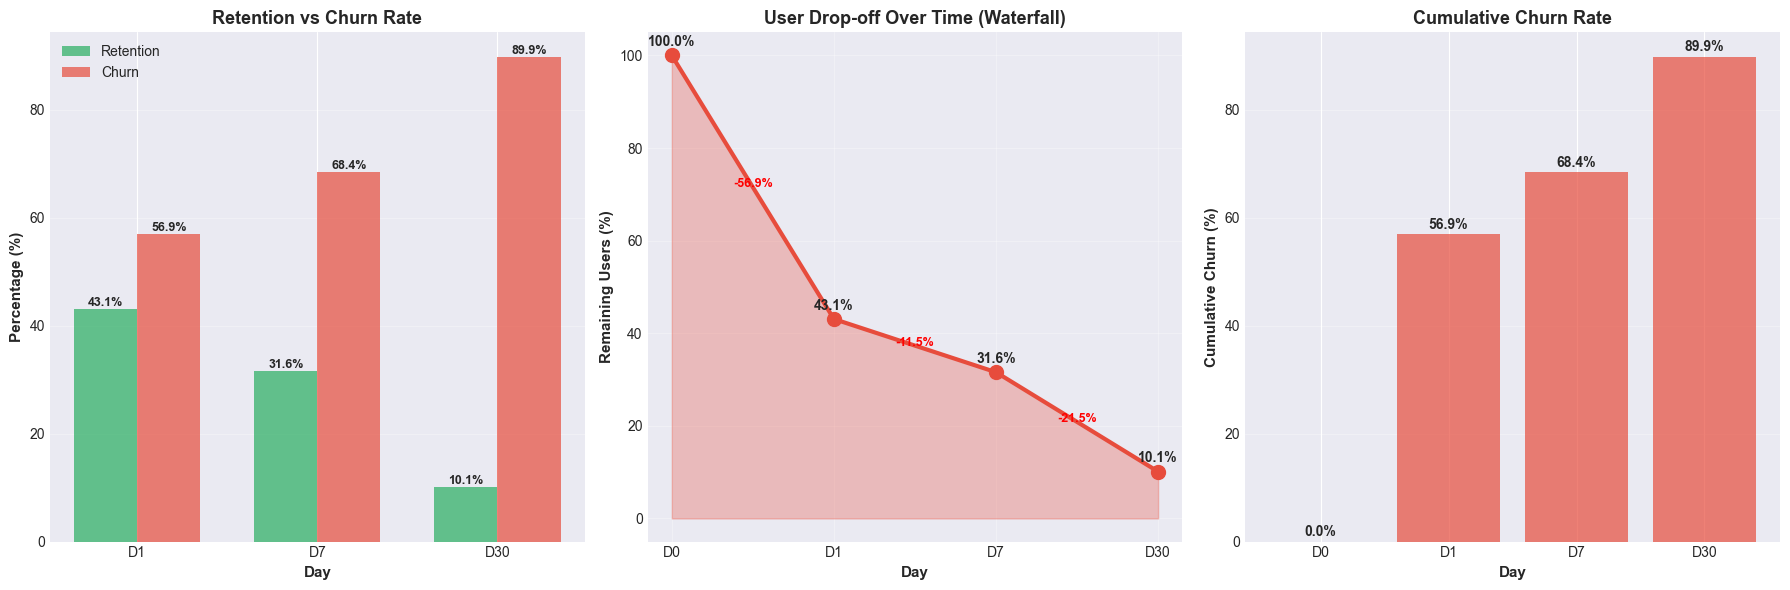


KEY INSIGHTS
• 56.9% пользователей уходят после первого дня
• Еще 11.5% уходят между D1 и D7
• Еще 21.5% уходят между D7 и D30
• Итого к D30 остается только 10.1% от изначальных пользователей


In [19]:
# Рассчитываем Churn Rate на основе retention
churn_data = {
    'Day': [1, 7, 30],
    'Retention (%)': [
        full_comparison['d1_retention'].mean(),
        full_comparison['d7_retention'].mean(),
        full_comparison['d30_retention'].mean()
    ]
}

churn_df = pd.DataFrame(churn_data)
churn_df['Churn Rate (%)'] = 100 - churn_df['Retention (%)']
churn_df['Cumulative Churn (%)'] = churn_df['Churn Rate (%)']

print("=" * 80)
print("CHURN RATE ANALYSIS")
print("=" * 80)
print(churn_df.to_string(index=False))

# Визуализация Churn Rate
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График 1: Retention vs Churn
x = np.arange(len(churn_df))
width = 0.35

bars1 = axes[0].bar(x - width/2, churn_df['Retention (%)'], width, 
                    label='Retention', color='#27ae60', alpha=0.7)
bars2 = axes[0].bar(x + width/2, churn_df['Churn Rate (%)'], width, 
                    label='Churn', color='#e74c3c', alpha=0.7)

axes[0].set_xlabel('Day', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Retention vs Churn Rate', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'D{day}' for day in churn_df['Day']])
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем значения на бары
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# График 2: Водопад Churn (Waterfall Chart)
retention_values = [100] + churn_df['Retention (%)'].tolist()
days_labels = ['D0'] + [f'D{day}' for day in churn_df['Day']]

axes[1].plot(days_labels, retention_values, marker='o', linewidth=3, 
             markersize=10, color='#e74c3c')
axes[1].fill_between(range(len(retention_values)), retention_values, 
                      alpha=0.3, color='#e74c3c')

for i, (day, ret) in enumerate(zip(days_labels, retention_values)):
    axes[1].text(i, ret + 2, f'{ret:.1f}%', ha='center', fontweight='bold')
    if i > 0:
        churn = retention_values[i-1] - ret
        axes[1].annotate(f'-{churn:.1f}%',
                        xy=(i-0.5, (retention_values[i-1] + ret)/2),
                        ha='center', fontsize=9, color='red', fontweight='bold')

axes[1].set_xlabel('Day', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Remaining Users (%)', fontsize=11, fontweight='bold')
axes[1].set_title('User Drop-off Over Time (Waterfall)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# График 3: Cumulative Churn
cumulative_churn = 100 - np.array(retention_values)

axes[2].bar(days_labels, cumulative_churn, color='#e74c3c', alpha=0.7)
axes[2].set_xlabel('Day', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Cumulative Churn (%)', fontsize=11, fontweight='bold')
axes[2].set_title('Cumulative Churn Rate', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

for i, (day, churn) in enumerate(zip(days_labels, cumulative_churn)):
    axes[2].text(i, churn + 1, f'{churn:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Дополнительный анализ
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print(f"• {churn_df['Churn Rate (%)'].iloc[0]:.1f}% пользователей уходят после первого дня")
print(f"• Еще {churn_df['Churn Rate (%)'].iloc[1] - churn_df['Churn Rate (%)'].iloc[0]:.1f}% уходят между D1 и D7")
print(f"• Еще {churn_df['Churn Rate (%)'].iloc[2] - churn_df['Churn Rate (%)'].iloc[1]:.1f}% уходят между D7 и D30")
print(f"• Итого к D30 остается только {churn_df['Retention (%)'].iloc[2]:.1f}% от изначальных пользователей")


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 2em 0 1em 0; border-left: 4px solid #667eea;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">6. Survival Rate & Cohort Analysis</h2>
</div>

### 📍 Определение

**Survival Rate (Кривая выживаемости)** — процент пользователей из когорты, которые остаются активными на каждый день после установки. Это полная картина удержания во времени.

### 📍 Формула расчета

Для каждого дня `n`:

$$
\text{Survival Rate (Day N)} = \frac{\text{Пользователи активные на Day N или позднее}}{\text{Размер когорты}} \times 100\%
$$

### 📍 Зачем нужна метрика

1. **Полная картина удержания** — видим поведение пользователей каждый день
2. **Анализ retention curve** — понимаем, где происходит наибольший отток
3. **Прогнозирование LTV** — используется в моделях расчета lifetime value
4. **Сравнение когорт** — позволяет сравнивать разные группы пользователей

### 📍 Расчет Survival Rate и Cohort Analysis


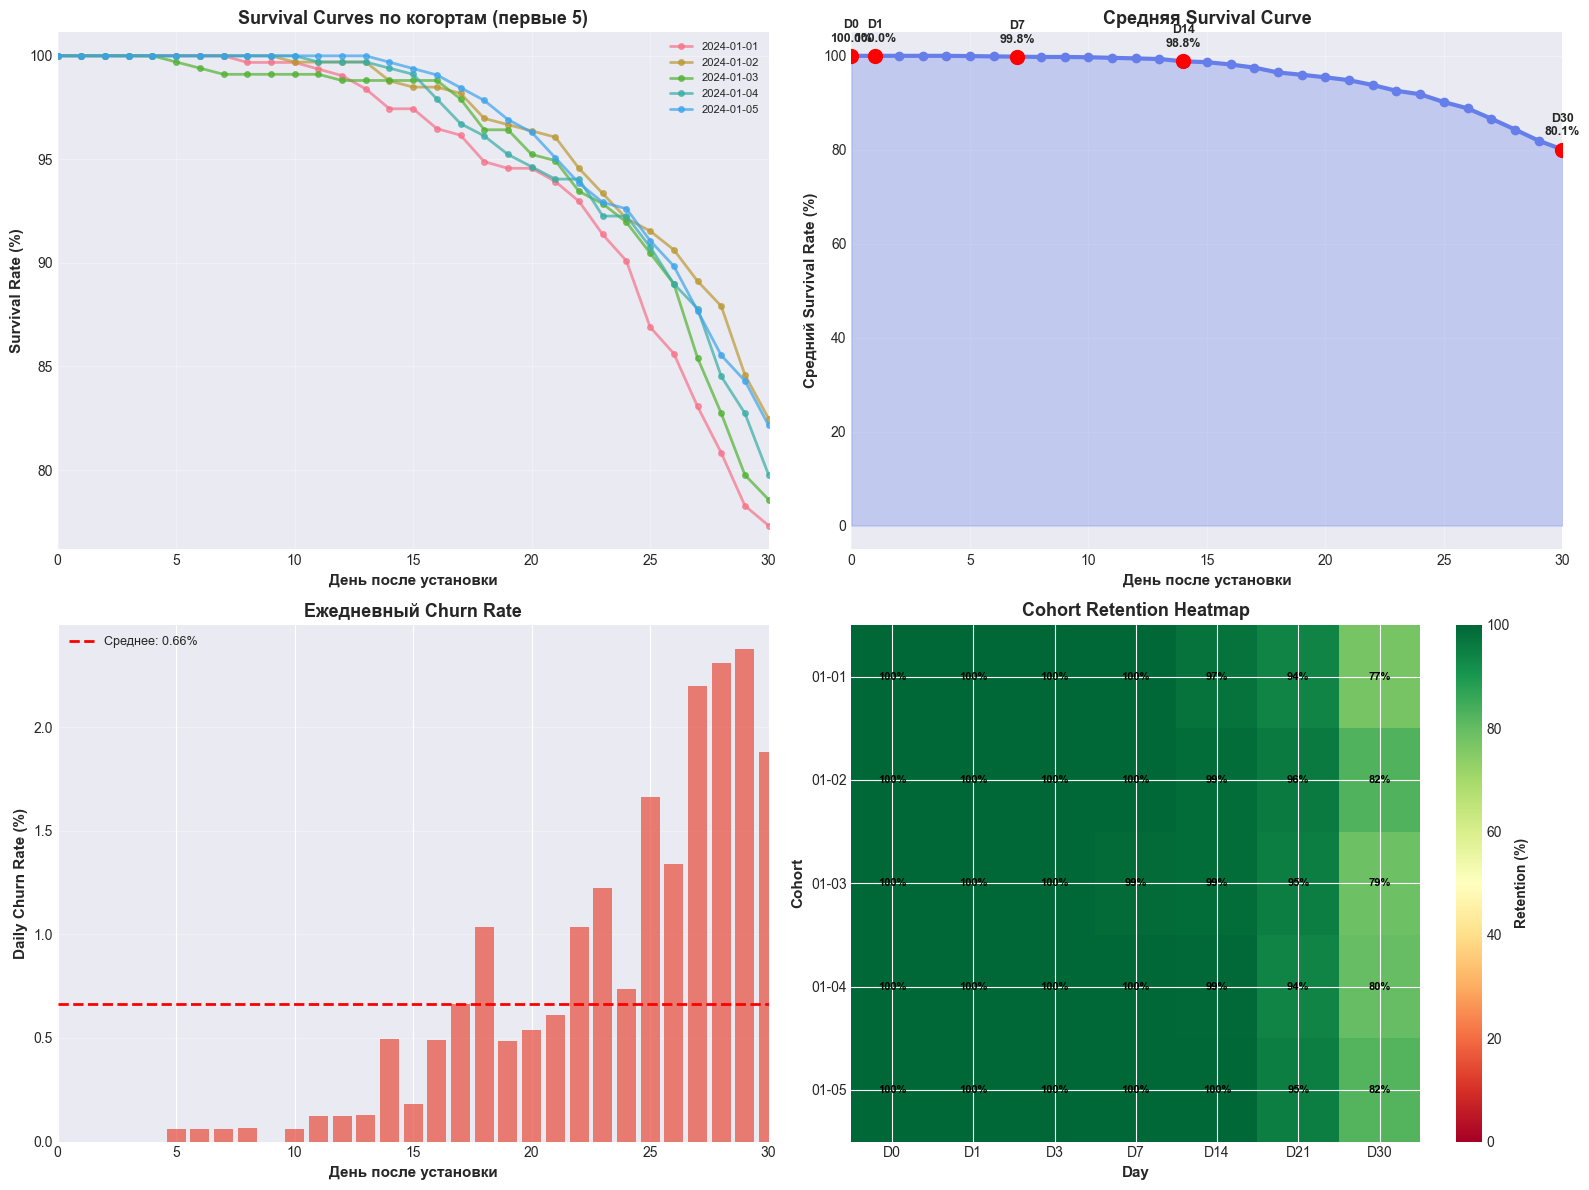

SURVIVAL CURVE STATISTICS
D0 (установка): 100.00%
D1: 100.00% (чurn: 0.00%)
D7: 99.82% (churn: 0.18%)
D30: 80.06% (churn: 19.94%)

Самый большой ежедневный отток: 2.37% на день 29
Средний ежедневный отток: 0.66%


In [17]:
def calculate_survival_curve(users_df, activities_df, cohort_date, max_days=60):
    """
    Рассчитывает кривую выживаемости для конкретной когорты
    
    Parameters:
    -----------
    users_df : pd.DataFrame
        DataFrame с пользователями
    activities_df : pd.DataFrame
        DataFrame с активностью
    cohort_date : datetime
        Дата когорты
    max_days : int
        Максимальное количество дней для анализа
    
    Returns:
    --------
    pd.DataFrame
        Таблица с survival rate по дням
    """
    
    cohort_users = users_df[users_df['install_date'] == cohort_date]['user_id'].unique()
    cohort_size = len(cohort_users)
    
    survival_rates = []
    
    for day in range(max_days + 1):
        target_date = cohort_date + timedelta(days=day)
        
        # Пользователи, активные на day N или позже
        active_users = activities_df[
            (activities_df['event_date'] >= target_date) &
            (activities_df['user_id'].isin(cohort_users))
        ]['user_id'].nunique()
        
        survival_rate = (active_users / cohort_size * 100) if cohort_size > 0 else 0
        
        survival_rates.append({
            'day': day,
            'active_users': active_users,
            'survival_rate': survival_rate
        })
    
    return pd.DataFrame(survival_rates)

# Берем несколько когорт для сравнения
selected_cohorts = sorted(users_df['install_date'].unique())[:5]  # Первые 5 когорт

# Рассчитываем survival curves для каждой когорты
survival_curves = {}
for cohort_date in selected_cohorts:
    survival_curves[cohort_date] = calculate_survival_curve(
        users_df, activities_df, cohort_date, max_days=30
    )

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Survival Curves для всех когорт
for cohort_date, curve_df in survival_curves.items():
    axes[0, 0].plot(curve_df['day'], curve_df['survival_rate'], 
                    marker='o', linewidth=2, markersize=4,
                    label=cohort_date.strftime('%Y-%m-%d'), alpha=0.7)

axes[0, 0].set_xlabel('День после установки', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Survival Rate (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Survival Curves по когортам (первые 5)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=8, loc='upper right')
axes[0, 0].set_xlim(0, 30)

# График 2: Средняя Survival Curve
avg_survival = pd.DataFrame({
    'day': range(31),
    'avg_survival_rate': [
        np.mean([curve['survival_rate'].iloc[day] 
                for curve in survival_curves.values() 
                if day < len(curve)])
        for day in range(31)
    ]
})

axes[0, 1].plot(avg_survival['day'], avg_survival['avg_survival_rate'], 
                marker='o', linewidth=3, markersize=6, color='#667eea')
axes[0, 1].fill_between(avg_survival['day'], avg_survival['avg_survival_rate'], 
                        alpha=0.3, color='#667eea')

# Добавляем ключевые точки
key_days = [0, 1, 7, 14, 30]
for day in key_days:
    if day < len(avg_survival):
        val = avg_survival['avg_survival_rate'].iloc[day]
        axes[0, 1].plot(day, val, 'ro', markersize=10)
        axes[0, 1].text(day, val + 3, f'D{day}\n{val:.1f}%', 
                       ha='center', fontsize=9, fontweight='bold')

axes[0, 1].set_xlabel('День после установки', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Средний Survival Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Средняя Survival Curve', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 30)

# График 3: Daily Churn Rate (ежедневный отток)
daily_churn = []
for i in range(1, len(avg_survival)):
    churn = avg_survival['avg_survival_rate'].iloc[i-1] - avg_survival['avg_survival_rate'].iloc[i]
    daily_churn.append(churn)

axes[1, 0].bar(range(1, len(avg_survival)), daily_churn, color='#e74c3c', alpha=0.7)
axes[1, 0].set_xlabel('День после установки', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Daily Churn Rate (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Ежедневный Churn Rate', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=np.mean(daily_churn), color='red', linestyle='--', 
                   linewidth=2, label=f'Среднее: {np.mean(daily_churn):.2f}%')
axes[1, 0].legend(fontsize=9)
axes[1, 0].set_xlim(0, 30)

# График 4: Cohort Heatmap
# Создаем таблицу retention по дням для каждой когорты
cohort_matrix = []
for cohort_date in selected_cohorts:
    row = [cohort_date.strftime('%m-%d')]
    curve = survival_curves[cohort_date]
    for day in [0, 1, 3, 7, 14, 21, 30]:
        if day < len(curve):
            row.append(curve['survival_rate'].iloc[day])
        else:
            row.append(0)
    cohort_matrix.append(row)

cohort_df = pd.DataFrame(cohort_matrix, 
                         columns=['Cohort', 'D0', 'D1', 'D3', 'D7', 'D14', 'D21', 'D30'])

# Создаем heatmap
im = axes[1, 1].imshow([row[1:] for row in cohort_matrix], 
                       cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(['D0', 'D1', 'D3', 'D7', 'D14', 'D21', 'D30'])
axes[1, 1].set_yticks(range(len(selected_cohorts)))
axes[1, 1].set_yticklabels([c.strftime('%m-%d') for c in selected_cohorts])

# Добавляем значения в ячейки
for i in range(len(selected_cohorts)):
    for j in range(7):
        text = axes[1, 1].text(j, i, f'{cohort_matrix[i][j+1]:.0f}%',
                              ha="center", va="center", color="black", 
                              fontsize=8, fontweight='bold')

axes[1, 1].set_title('Cohort Retention Heatmap', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Day', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Cohort', fontsize=11, fontweight='bold')

# Добавляем colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Retention (%)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Выводим статистику
print("=" * 80)
print("SURVIVAL CURVE STATISTICS")
print("=" * 80)
print(f"D0 (установка): {avg_survival['avg_survival_rate'].iloc[0]:.2f}%")
print(f"D1: {avg_survival['avg_survival_rate'].iloc[1]:.2f}% (чurn: {100 - avg_survival['avg_survival_rate'].iloc[1]:.2f}%)")
print(f"D7: {avg_survival['avg_survival_rate'].iloc[7]:.2f}% (churn: {100 - avg_survival['avg_survival_rate'].iloc[7]:.2f}%)")
print(f"D30: {avg_survival['avg_survival_rate'].iloc[30]:.2f}% (churn: {100 - avg_survival['avg_survival_rate'].iloc[30]:.2f}%)")
print(f"\nСамый большой ежедневный отток: {max(daily_churn):.2f}% на день {daily_churn.index(max(daily_churn)) + 1}")
print(f"Средний ежедневный отток: {np.mean(daily_churn):.2f}%")


## 📍 Резюме и Best Practices

### Ключевые выводы по Retention метрикам

**Критически важные метрики:**
- D1 Retention — первый индикатор качества продукта
- D7 Retention — предиктор среднесрочной вовлеченности
- D30 Retention — индикатор долгосрочной ценности

**Важные метрики:**
- Rolling Retention — для casual игр
- Churn Rate — для анализа оттока
- Survival Curve — для глубокого анализа

### Типичные соотношения

| Соотношение | Здоровое значение | Интерпретация |
|-------------|-------------------|---------------|
| D7/D1 | 40-60% | Хорошее среднесрочное удержание |
| D30/D7 | 40-60% | Стабильная база пользователей |
| D30/D1 | 15-30% | Сильная долгосрочная вовлеченность |

### Red Flags (Тревожные сигналы)

- D1 < 25% — серьезные проблемы с FTUE
- D7/D1 < 30% — слабый core loop
- D30/D7 < 30% — недостаток контента
- Резкое падение между D1-D3 — проблемы с ранней прогрессией

### Как улучшить Retention

**День 0-1 (D1):**
- Упростить онбординг
- Ранние победы (quick wins)
- Push через 12-18 часов

**День 1-7 (D7):**
- Достаточно контента на неделю
- Daily login rewards
- События для новичков
- Социальные features

**День 7-30 (D30):**
- End-game контент
- Гильдии и PvP
- Регулярные обновления
- Мета-прогрессия


In [18]:
print("=" * 80)
print("ИТОГОВАЯ СВОДКА ПО RETENTION METRICS")
print("=" * 80)
print()
print("Метрики, рассчитанные в этом ноутбуке:")
print()
print(f"✓ D1 Retention:  {full_comparison['d1_retention'].mean():.2f}%")
print(f"✓ D7 Retention:  {full_comparison['d7_retention'].mean():.2f}%")
print(f"✓ D30 Retention: {full_comparison['d30_retention'].mean():.2f}%")
print()
print(f"✓ D7/D1 Ratio:   {(full_comparison['d7_retention'].mean() / full_comparison['d1_retention'].mean() * 100):.1f}%")
print(f"✓ D30/D7 Ratio:  {(full_comparison['d30_retention'].mean() / full_comparison['d7_retention'].mean() * 100):.1f}%")
print(f"✓ D30/D1 Ratio:  {(full_comparison['d30_retention'].mean() / full_comparison['d1_retention'].mean() * 100):.1f}%")
print()
print(f"✓ Rolling D7:    {rolling_d7_results['rolling_d7_retention'].mean():.2f}%")
print(f"✓ Churn Rate D1: {100 - full_comparison['d1_retention'].mean():.2f}%")
print(f"✓ Churn Rate D7: {100 - full_comparison['d7_retention'].mean():.2f}%")
print(f"✓ Churn Rate D30:{100 - full_comparison['d30_retention'].mean():.2f}%")
print()
print("=" * 80)
print("Количество проанализированных пользователей:", len(users_df))
print("Количество когорт:", len(users_df['install_date'].unique()))
print("Период наблюдения: 60 дней")
print("=" * 80)
print()
print("✅ Анализ retention метрик завершен успешно!")
print()
print("Следующие шаги:")
print("  1. Применить эти расчеты к реальным данным")
print("  2. Сегментировать пользователей (organic/paid, geo, platform)")
print("  3. Проводить A/B тесты для улучшения retention")
print("  4. Создать automated dashboards для мониторинга")
print("=" * 80)


ИТОГОВАЯ СВОДКА ПО RETENTION METRICS

Метрики, рассчитанные в этом ноутбуке:

✓ D1 Retention:  43.07%
✓ D7 Retention:  31.58%
✓ D30 Retention: 10.12%

✓ D7/D1 Ratio:   73.3%
✓ D30/D7 Ratio:  32.0%
✓ D30/D1 Ratio:  23.5%

✓ Rolling D7:    99.80%
✓ Churn Rate D1: 56.93%
✓ Churn Rate D7: 68.42%
✓ Churn Rate D30:89.88%

Количество проанализированных пользователей: 10000
Количество когорт: 30
Период наблюдения: 60 дней

✅ Анализ retention метрик завершен успешно!

Следующие шаги:
  1. Применить эти расчеты к реальным данным
  2. Сегментировать пользователей (organic/paid, geo, platform)
  3. Проводить A/B тесты для улучшения retention
  4. Создать automated dashboards для мониторинга
